# Example 1

This is an example that reproduces Figure 3 (up to iteration 50) from Genkin, M., Engel, T.A., Nat Mach Intell 2, 674–683 (2020).
It also calculates validated negative loglikelihood at each iteration and plots it next to the training negative loglikelihood. 

In [2]:
import neuralflow
import numpy as np
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec
import logging
logging.basicConfig(level=logging.INFO)

## Step 1: Generate synthetic data

1) Specify the grid. Here we initialize a grid with Ne = 256 elements and Np = 8 points per element. The total number of points in the grid is N = (Np-1) * Ne + 1 = 1793.
2) Specify the ground-truth model gt_model for data generation. We use double-well model (as in main text FIG. 3, 4), noise magnitude `D0=10`, 1 neural response with the firing rate function `f(x) = 100*(x+1)` hz. Setting p0 to None will initialize an equilirium model.
3) Initialize data generator using gt_model, reflecting boundary mode (so that the latent trajectory will bounce off the boudaries) and also do not record the trial end time (consistent with the 2020 Nat. Mach. Intel. paper).
4) Generate 2 trials of data, where each trial starts at `t=0` and ends at `t=100s`.
5) Split the data into training and validation by initializing SpikeData objects.

In [3]:
grid = neuralflow.GLLgrid(Np = 8, Ne = 256)
gt_model = neuralflow.model.new_model(
    peq_model = {"model": "double_well", "params": {"xmin": 0.6, "xmax": 0.0, "depth": 2}},
    p0_model = None,
    D = 10,
    fr_model = [{"model": "rectified_linear", "params": {"slope": 100, "x_thresh": -1}}],
    grid = grid
)

data_generator = neuralflow.SyntheticData(gt_model, 'reflecting', record_trial_end = False)

data, time_bins, diff_traj = data_generator.generate_data(trial_start = 0, trial_end = 100, num_trials = 2)

dataTR=neuralflow.SpikeData(data[[0]], with_trial_end = False)
dataCV=neuralflow.SpikeData(data[[1]], with_trial_end = False)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:13<00:00,  6.56s/it]


## Step 2: Perform model optimization
1) Create another model that will be our initial guess. This model is the same as the ground-truth but with different equilibrium probability distribution `peq`, which defines a different potential.
2) Define optimization parameters: 50 epochs, 1 iteration per epoch, optimize the driving force, and specify gradient-descent learning rate. 
3) Define gradient-descent optimization object. In addition, limit the number of eigenvectors and eigenvalues of the $\mathcal{H}$ operator for the likelihood and gradients calculations to `Nv=64` (for the case of absorbing boundary one would use the default value of this parameter). 
4) Perform optimization. Note that we optimize the driving force $F(x)$, while the results are saved in the form of equilibrium probability distribution $p_{\rm eq}(x)$, and we will visualize the results in terms of potential $\Phi(x)$ later.

In [4]:
initial_guess_model = neuralflow.model.new_model(
    peq_model = {"model": "cos_square", "params": {}},
    p0_model = None,
    D = 10,
    fr_model = [{"model": "rectified_linear", "params": {"slope": 100, "x_thresh": -1}}],
    grid = grid
)

opt_params = {'max_epochs': 50, 'mini_batch_number': 1, 'params_to_opt': 'F', 'learning_rate': {'F': 0.005}}

optimization = neuralflow.Optimization(dataTR, init_model = initial_guess_model, optimizer_name = 'GD', opt_options = opt_params, 
                        pde_solve_params = {'Nv' : 64}, boundary_mode='reflecting', dataCV=dataCV)

optimization.run_optimization()

INFO:neuralflow.base_optimizer:Path is not specified. The results will only be saved in RAM
INFO:neuralflow.base_optimizer:sim_start not provided, setting to zero
INFO:neuralflow.base_optimizer:Setting saving schedule to default: save every epoch
100%|██████████| 50/50 [03:14<00:00,  3.89s/it]
INFO:neuralflow.optimization:Optimization completed


## Step 3: Visualize the results

INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode


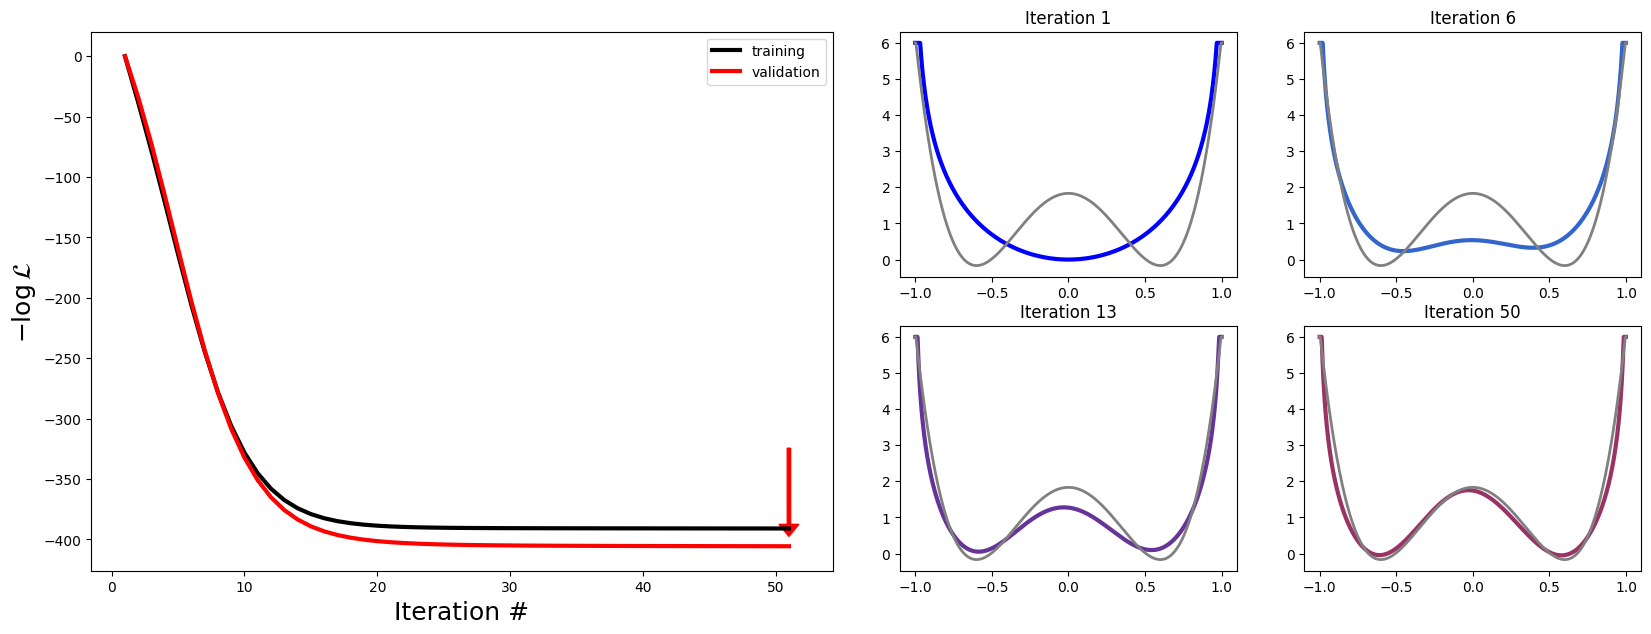

In [5]:
lls = optimization.results['logliks'][0]
lls_CV = optimization.results['logliksCV'][0]

#Shift training and validated loglikelihoods such that they both start from 0 for visualisation purposes
lls= (lls-lls[0])
lls_CV=(lls_CV-lls_CV[0])

fig=plt.figure(figsize=(20,7))
gridspec.GridSpec(2,4)
Iterations=[1,6,13,50]
colors=[[0.0, 0.0, 1.0],
        [0.2, 0.4, 0.8],
        [0.4, 0.2, 0.6],
        [0.6, 0.2, 0.4]]

# Plot negative loglikelihood vs. iteration number
plt.subplot2grid((2,4), (0,0), colspan=2, rowspan=2)

plt.plot(np.arange(1,lls.size+1), lls, color='black', linewidth=3, label='training')
plt.plot(np.arange(1,lls_CV.size+1), lls_CV, color='red', linewidth=3, label='validation')
plt.xlabel('Iteration #', fontsize=18)
plt.ylabel(r'$-\log\mathcal{L}$', fontsize=18)
plt.legend()

#Point at iteration with minCV
minCV, ysize=np.argmin(lls_CV)+1, -np.min(lls_CV)/5
plt.arrow(minCV,lls_CV[minCV-1]+ysize,0,-ysize*0.9,width=0.25,length_includes_head=True,head_width=1.5,head_length=10, color='red')

#Plot potentials. Potential is calculated from peq by taking negative log: Phi = - log(peq). 
for i,Iter in enumerate(Iterations):
    plt.subplot2grid((2,4), (i//2,2+i%2))
    plt.plot(gt_model.grid.x_d, np.minimum(-np.log(optimization.results['peq'][Iterations[i]-1][0,:]),6), color=colors[i] ,linewidth=3)
    plt.plot(gt_model.grid.x_d, np.minimum(-np.log(gt_model.peq[0,:]),6), color='grey', linewidth=2)
    plt.title('Iteration {}'.format(Iterations[i])) 